In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Convolve
from scipy.ndimage import gaussian_filter1d
from cca_zoo.linear import rCCA
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# Directories
main_dir = os.getcwd()
model_cache_dir = os.path.join(main_dir, '..', 'model_cache')

# Set default type now
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

# To-do list:
- [X] Image based method
    - [X] Drop in CNN MLP code
    - [X] Implement window size, batching

- [] Remove chunked inference, it has issues. Swap to CPU based inference, only run post-hoc

- [] Try ISI encoding instead (as in https://pmc.ncbi.nlm.nih.gov/articles/PMC9870156/)

- [/] Parallel training with shared memory, fixed to have the right number of processes


In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: cuda


In [3]:
# To be fully centered kernel should have odd number of elements!
# Requires torch tensors as both inputs
def convolve_spike_train(X, kernel):
    kernel_len = len(kernel)
    offset = (kernel_len - 1) // 2
    all_inds = torch.nonzero(X, as_tuple=True)
    # Create output array as zero-padded input 
    X = torch.zeros(X.shape[0], X.shape[1] + 2 * offset, dtype=kernel.dtype)
    # Can't think of a way to do this vectorized b/c I'm lazy
    for i in range(X.shape[0]):
        inds = all_inds[1][all_inds[0] == i] + offset
        for j in inds:
            low_ind = j - offset
            high_ind = j - offset + kernel_len
            X[i,low_ind:high_ind] += kernel
    # Remove padding
    X = X[:, offset:-offset]
    return X

Neurons (X): torch.Size([32, 3731116])
Muscles (Y): torch.Size([10, 3731116])
Neuron Labels: ['87', '29', '1', '78', '12', '20', '2', '6', '41', '11', '13', '65', '89', '15', '75', '42', '33', '28', '14', '39', '21', '7', '96', '68', '8', '88', '93', '26', '10', '0', '30', '3']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


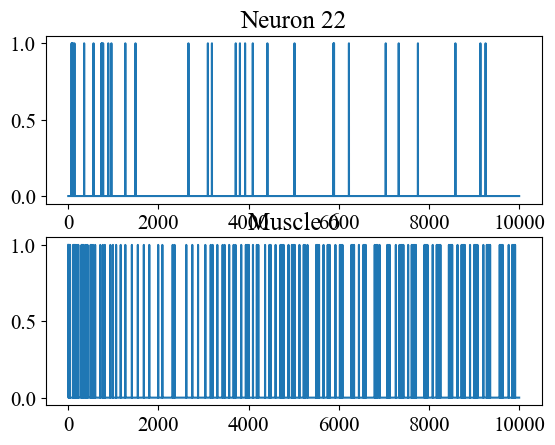

In [4]:
# Read the data and have some binning
data_dir = os.path.join(os.getcwd(), '..', 'data_for_python')
X, Y, x_labels, y_labels = process_spike_data(os.path.join(data_dir, '2025-03-21'), 0.0005)
# Convert to torch tensors, "Convolve" with gaussian to get continuous form
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
# kernel = torch.signal.windows.gaussian(51, std=10, dtype=torch.float32).type(default_dtype)
# X, Y = convolve_spike_train(X, kernel), convolve_spike_train(Y, kernel)
# # Clip low values to zero so batch detection works okay
# X[X < 0.01] = 0.
# Y[Y < 0.01] = 0.
# # Rescale all values to same scale
# maxval = torch.maximum(X.max(), Y.max())
# X /= maxval
# Y /= maxval

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

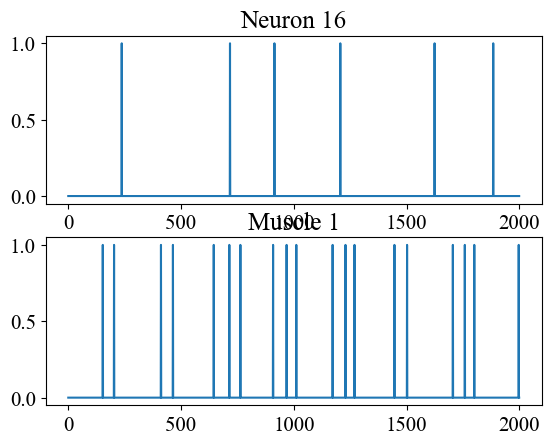

In [5]:
pl = 2000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

In [5]:
params = {
    # Optimizer parameters (for training)
    'epochs': 200,
    'batch_size': 128,
    'learning_rate': 8e-3,
    'n_trials': 3,
    'patience': 10,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    'layers': 3,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.Softplus, #'leaky_relu',
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'chunked_inference': False, 
    'chunk_size': 1000,
}

In [6]:
def create_cnn_data_split(dataset, batch_size, train_fraction=0.95, eval_fraction=None, eval_from_train=True, device=None):
    """
    Creates train loader and test/eval data views
    Args:
        dataset (FullAndBatchedDataset): The dataset containing all data
        train_fraction (float): Fraction of batches to use for training
        device (torch.device): Device to move test/eval data to
        
    Returns:
        tuple: (train_loader, test_data, eval_data)
    """
    # Generate train/test splits
    train_size = int(train_fraction * len(dataset.batch_indices))
    # Create train/test/eval indices, separate eval set with different random indices
    traintest_indices = torch.randperm(len(dataset.batch_indices))
    train_indices = traintest_indices[:train_size]
    test_indices = traintest_indices[train_size:]
    # Generate eval split, either from train subset or independently
    eval_fraction = (1 - train_fraction) if eval_fraction is None else eval_fraction
    eval_size = int(eval_fraction * len(dataset.batch_indices))
    if eval_from_train:
        eval_indices = traintest_indices[:eval_size]
    else:
        eval_indices = torch.randperm(len(dataset.batch_indices))[:eval_size]
    # Create training data loader, send test and eval to device
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(train_indices),
        num_workers=0  # Adjust based on your system
    )
    # Get test and eval data as views. Batches are sorted to be presented in real data order
    test_loader = DataLoader(dataset, batch_size=len(test_indices), sampler=SubsetRandomSampler(test_indices))
    eval_loader = DataLoader(dataset, batch_size=len(eval_indices), sampler=SubsetRandomSampler(eval_indices))
    return train_loader, test_loader, eval_loader

# Might not need eval at all, if windows are small enough

In [7]:

def train_cnn_model(model_func, full_dataset, params, device=device):
    """
    Generalized training function for DSIB and DVSIB models with early stopping.
    Version that does not run evaluation! Skimps on that to save time, returns only mi values from test
    Args:
        model: The model to train (DSIB or DVSIB).
        data: Tuple of (train, test, eval) dataloaders. 
            Assumes uses BatchSubsetDataset with custom sampler
            Assumes loaders return X, Y of shapes (M_x, N) and (M_y, N)
    Returns:
        An array test_estimates containing mutual information estimates of TEST SET ONLY
    """
    # Initialize model
    model_name = model_func.__name__
    model = model_func(params)
    model.to(device)  # Ensure model is on GPU
    # Pull out data loaders
    train_data, test_loader, eval_loader = full_dataset
    # Pull out test data. Loader just constructs a giant single batch
    test_X, test_Y = list(iter(test_loader))[0]
    test_X, test_Y = test_X.unsqueeze(1).to(device), test_Y.unsqueeze(1).to(device)
    eval_X, eval_Y = list(iter(eval_loader))[0]
    eval_X, eval_Y = eval_X.unsqueeze(1).to(device), eval_Y.unsqueeze(1).to(device)
    # Initialize variables
    epochs = params['epochs']
    opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], eps=params['eps'])
    estimates_mi_test = []
    estimates_mi_train = []
    best_estimator_ts = float('-inf')  # Initialize with negative infinity
    no_improvement_count = 0
    for epoch in range(epochs):
        start = time.time()
        for i, (x, y) in enumerate(iter(train_data)):
            # Add extra dim to represent number of channels (1 because "images" are one-hot encoded, no RGB)
            x, y = x.unsqueeze(1).to(device), y.unsqueeze(1).to(device)
            opt.zero_grad()
            # Compute loss based on model type
            if model_name == "DSIB":
                loss = model(x, y)  # DSIB returns a single loss
            elif model_name == "DVSIB":
                loss, _, _ = model(x, y)  # DVSIB returns three outputs
            else:
                raise ValueError("Invalid model_type. Choose 'DSIB' or 'DVSIB'.")
            loss.backward()
            opt.step()
        print(f'Train time = {time.time() - start}')
        # Test model at every epoch
        with torch.no_grad():
            if model_name == "DSIB":
                start = time.time()
                estimator_tr = -model(eval_X, eval_Y)
                print(f'Eval time = {time.time() - start}')
                start = time.time()
                estimator_ts = -model(test_X, test_Y)
                print(f'Test time = {time.time() - start}')
            elif model_name == "DVSIB": # Get lossGout, that is the mi value
                _, _, estimator_ts = model(test_X, test_Y)
            estimator_tr = estimator_tr.to('cpu').detach().numpy()
            estimator_ts = estimator_ts.to('cpu').detach().numpy()
            estimates_mi_train.append(estimator_tr)
            estimates_mi_test.append(estimator_ts)
        print(f"Epoch: {epoch+1}, {model_name}, train: {estimator_tr}, test: {estimator_ts}", flush=True)
        # Check for improvement, negative values, or nans
        if np.isnan(estimator_tr) and np.isnan(estimator_ts):
            print('Early stop due to nan outputs')
            break
        if estimator_ts < 0:
            no_improvement_count += 1
        elif estimator_ts > best_estimator_ts + params['min_delta']:
            # We have an improvement
            best_estimator_ts = estimator_ts
            no_improvement_count = 0
        else:
            # No significant improvement
            no_improvement_count += 1
        # Check if we should stop early
        if no_improvement_count >= params['patience']:
            print(f"Early stopping triggered after {epoch+1} epochs. Best estimator_ts: {best_estimator_ts}")
            break
    return np.array(estimates_mi_train), np.array(estimates_mi_test), model

def train_cnn_model_no_eval(model_func, full_dataset, params, model_save_dir, device=device):
    """
    Generalized training function for DSIB and DVSIB models with early stopping.
    Version that does not run evaluation! Skimps on that to save time, returns only mi values from test
    Args:
        model: The model to train (DSIB or DVSIB).
        data: Tuple of (train, test, eval) dataloaders. 
            Assumes uses BatchSubsetDataset with custom sampler
            Assumes loaders return X, Y of shapes (M_x, N) and (M_y, N)
    Returns:
        An array test_estimates containing mutual information estimates of TEST SET ONLY
    """
    # Initialize model
    model_name = model_func.__name__
    model = model_func(params)
    model.to(device)  # Ensure model is on GPU
    # Make save directory if it doesn't exist, generate unique model id
    os.makedirs(model_save_dir, exist_ok=True)
    train_id = model_name + '_' + f'dz-{params["embed_dim"]}_' + f'bs-{params["batch_size"]}_' + str(uuid.uuid4())
    # Pull out data loaders
    train_data, test_loader, _ = full_dataset
    # Pull out test data. Loader just constructs a giant single batch
    test_X, test_Y = list(iter(test_loader))[0]
    test_X, test_Y = test_X.unsqueeze(1).to(device), test_Y.unsqueeze(1).to(device)
    # Initialize variables
    epochs = params['epochs']
    opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], eps=params['eps'])
    estimates_mi_test = []
    best_estimator_ts = float('-inf')  # Initialize with negative infinity
    no_improvement_count = 0
    for epoch in range(epochs):
        start = time.time()
        for i, (x, y) in enumerate(iter(train_data)):
            # Add extra dim to represent number of channels (1 because "images" are one-hot encoded, no RGB)
            x, y = x.unsqueeze(1).to(device), y.unsqueeze(1).to(device)
            opt.zero_grad()
            # Compute loss based on model type
            if model_name == "DSIB":
                loss = model(x, y)  # DSIB returns a single loss
            elif model_name == "DVSIB":
                loss, _, _ = model(x, y)  # DVSIB returns three outputs
            else:
                raise ValueError("Invalid model_type. Choose 'DSIB' or 'DVSIB'.")
            loss.backward()
            opt.step()
        print(f'Train time = {time.time() - start}')
        # Test model at every epoch
        with torch.no_grad():
            if model_name == "DSIB":
                start = time.time()
                estimator_ts = -model(test_X, test_Y)
                print(f'Test time = {time.time() - start}')
            elif model_name == "DVSIB": # Get lossGout, that is the mi value
                _, _, estimator_ts = model(test_X, test_Y)
            estimator_ts = estimator_ts.to('cpu').detach().numpy()
            estimates_mi_test.append(estimator_ts)
        print(f"Epoch: {epoch+1}, {model_name}, test: {estimator_ts}", flush=True)
        # Save snapshot of model
        torch.save(
            model, 
            os.path.join(model_save_dir, f'epoch{epoch}_' + train_id + '.pt')
        )
        # Check for improvement, negative values, or nans
        if np.isnan(estimator_ts):
            print('Early stop due to nan outputs')
            break
        if estimator_ts < 0:
            no_improvement_count += 1
        elif estimator_ts > best_estimator_ts + params['min_delta']:
            # We have an improvement
            best_estimator_ts = estimator_ts
            no_improvement_count = 0
        else:
            # No significant improvement
            no_improvement_count += 1
        # Check if we should stop early
        if no_improvement_count >= params['patience']:
            print(f"Early stopping triggered after {epoch+1} epochs. Best estimator_ts: {best_estimator_ts}")
            break
    return np.array(estimates_mi_test), train_id


In [8]:
torch.cuda.empty_cache()
this_params = {**params, 'embed_dim': 10, 'batch_size': 256}
dataset = BatchedDataset(X, Y, this_params['batch_size'])
full_dataset = create_cnn_data_split(dataset, batch_size=60, train_fraction=0.9, eval_fraction=0.9, device=device)
mis, mis_test, mod = train_cnn_model(DSIB, full_dataset, this_params)
# misv, misv_test = train_model(DVSIB, full_dataset, this_params)

Train time = 2.039194107055664
Eval time = 0.25301671028137207
Test time = 0.006006717681884766
Epoch: 1, DSIB, train: -0.00021080582519061863, test: -0.00021096218551974744
Train time = 1.3562345504760742
Eval time = 0.0020034313201904297
Test time = 0.0010001659393310547
Epoch: 2, DSIB, train: 1.728738243400585e-05, test: 5.8151348639512435e-05
Train time = 1.363241195678711
Eval time = 0.002001523971557617
Test time = 0.002002239227294922
Epoch: 3, DSIB, train: 0.00010286056203767657, test: 0.00017332297284156084
Train time = 1.3572354316711426
Eval time = 0.0020020008087158203
Test time = 0.0010013580322265625
Epoch: 4, DSIB, train: 0.000529260840266943, test: 0.0007416916778311133
Train time = 1.3530664443969727
Eval time = 0.0020008087158203125
Test time = 0.0020024776458740234
Epoch: 5, DSIB, train: 0.022847218438982964, test: 0.028985116630792618
Train time = 1.3602375984191895
Eval time = 0.0020012855529785156
Test time = 0.0020029544830322266
Epoch: 6, DSIB, train: 0.05511956

In [9]:
torch.cuda.empty_cache()
full_dataset = create_cnn_data_split(dataset, batch_size=60, train_fraction=0.5, eval_fraction=0.9, device=device)
train_data, test_loader, eval_loader = full_dataset
# Pull out test data. Loader just constructs a giant single batch
test_X, test_Y = list(iter(test_loader))[0]
test_X, test_Y = test_X.unsqueeze(1).to(device), test_Y.unsqueeze(1).to(device)
for i in np.linspace(0.1, 1.0, 2):
    frac = int(i * test_X.shape[0])
    print(-mod(test_X[0:frac,:,:,:], test_Y[0:frac,:,:,:]))
    torch.cuda.empty_cache()

tensor(1.0469, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1.0675, device='cuda:0', grad_fn=<NegBackward0>)


Text(0, 0.5, 'MI')

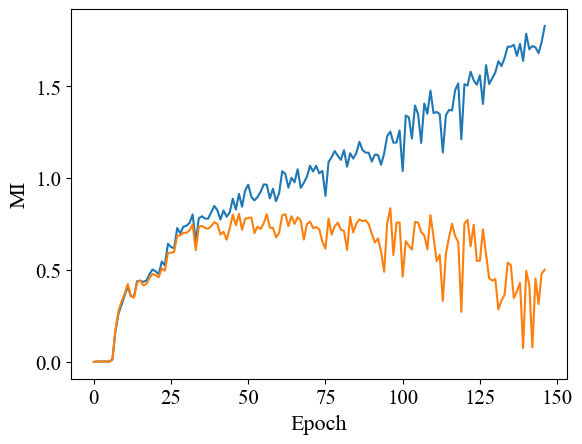

In [21]:
plt.plot(mis)
plt.plot(mis_test)
plt.xlabel('Epoch')
plt.ylabel('MI')

Things to know:

- What batch size, embed_dim work best?
- What effect does meta/actual batch size have?


144 runs took ~ 5 hours

In [ ]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([64, 128, 256, 512])

for bs in batch_size_range:
    dataset = BatchedDataset(X, Y, bs)
    for dz in tqdm(range(1, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            dataset = BatchedDataset(X, Y, this_params['batch_size'])
            full_dataset = create_cnn_data_split(dataset, batch_size=30, train_fraction=0.9, eval_fraction=0.9, device=device)
            mis, mis_test = train_cnn_model(DSIB, full_dataset, this_params)
            # full_dataset = create_cnn_data_split(dataset, train_fraction=0.9, eval_fraction=0.9, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            # mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            # mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi[key] = mis
            mi_test[key] = mis_test
            # models[key] = mod
            # ids[key] = train_id
torch.cuda.empty_cache()


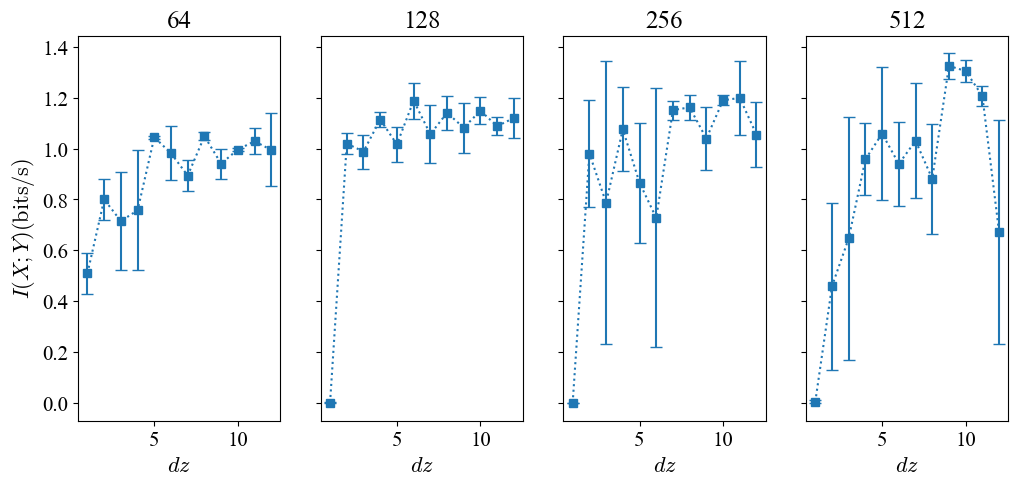

In [38]:
# Define sigma, a small number is usually the best choice
sigma=1 # (or 2 at most)

fig, ax = plt.subplots(1, len(batch_size_range), figsize=(12,5), sharey=True)
for i,bs in enumerate(batch_size_range):    
    dz_means, dz_stds = [], []
    dz_train_means, dz_train_stds = [], []
    for dz in range(1, params['max_dz']+1):
        mi_trials = []
        mi_train = []
        for j in range(params['n_trials']):
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            # Convert Nan to zeros and smooth
            # test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) / bs * np.log2(np.e) * 1000
            train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma) * np.log2(np.e)# / (0.0005 * bs)
            test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) * np.log2(np.e)# / (0.0005 * bs)
            # Pick the epoch with highest test value and get corresponding train
            best = np.argmax(test)
            mi_trials.append(test[best])
            mi_train.append(train[best])
        dz_means.append(np.mean(np.array(mi_trials)).flatten())
        dz_stds.append(np.std(np.array(mi_trials)).flatten())
        dz_train_means.append(np.mean(np.array(mi_train)).flatten())
        dz_train_stds.append(np.std(np.array(mi_train)).flatten())
    b = ax[i].errorbar(
        range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
        yerr=np.array(dz_stds).flatten(), 
        fmt='s:', capsize=4)
    # ax[i].errorbar(
    #     range(1, params['max_dz']+1), np.array(dz_train_means).flatten(), 
    #     yerr=np.array(dz_train_stds).flatten(), 
    #     fmt='s:', capsize=4)

    # Set title and scales
    ax[i].set_title(str(bs))
    ax[i].set_xlabel(r'$dz$')
    if i == 0:
        ax[i].set_ylabel(r'$I(X;Y) \text{(bits/s)}$');
    # ax[i].set_ylim(-1, 4)


trial_0_dz_10_bs_64


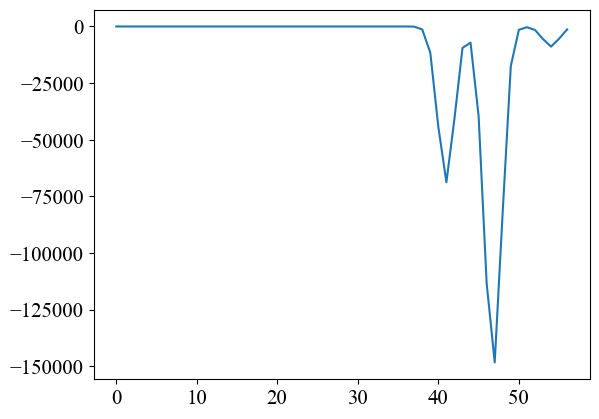

In [72]:
key = random.choice(list(mi_test.keys()))
sigma = 1
# plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]) * np.log2(np.e), sigma=sigma))
# plt.gca().set_ylim(0)
print(key)

In [82]:
import pickle

with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(mi_test, f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(ids, f)


In [91]:
ids

{'trial_0_dz_5_bs_64': 'DSIB_dz-5_bs-64_8fd6f693-0e8c-4050-80f0-71743727faf4',
 'trial_1_dz_5_bs_64': 'DSIB_dz-5_bs-64_53c1ac4c-c23f-4fb7-b0de-03609854555d',
 'trial_2_dz_5_bs_64': 'DSIB_dz-5_bs-64_980c7b88-ae7e-45c8-8654-43988f324259',
 'trial_0_dz_6_bs_64': 'DSIB_dz-6_bs-64_f5780180-bfd3-435e-b811-ea7695d4a1b5',
 'trial_1_dz_6_bs_64': 'DSIB_dz-6_bs-64_bd177624-0f1d-47e3-9b66-3efe1affcb26',
 'trial_2_dz_6_bs_64': 'DSIB_dz-6_bs-64_e444d9e9-1f41-4509-8b87-95f2bcb4c6ba',
 'trial_0_dz_7_bs_64': 'DSIB_dz-7_bs-64_9dc5f773-c58a-41b1-8d58-f154bc18fe83',
 'trial_1_dz_7_bs_64': 'DSIB_dz-7_bs-64_136f4efa-0772-4a42-b8d1-163fcca65eda',
 'trial_2_dz_7_bs_64': 'DSIB_dz-7_bs-64_aa666a3e-dd74-47c8-9e75-a2260fe347af',
 'trial_0_dz_8_bs_64': 'DSIB_dz-8_bs-64_aaf1e6a7-8d80-4aba-bfe0-8fc840cb522f',
 'trial_1_dz_8_bs_64': 'DSIB_dz-8_bs-64_ef96a2d7-2bcc-45d7-b9ec-20ad29bfc0a7',
 'trial_2_dz_8_bs_64': 'DSIB_dz-8_bs-64_b53fd0ff-c038-4b42-b96d-2a9a32ea69e8',
 'trial_0_dz_9_bs_64': 'DSIB_dz-9_bs-64_6ce81eb9-0f7

In [ ]:
with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes